In [6]:
import numpy as np
# import xrft
import sys
import matplotlib.pyplot as plt
import os
import xarray as xr
sys.path.append("/home/149/ab8992/tasman-tides/")
# import xarray as xr
import ttidelib as tt
from dask.distributed import Client
# client = Client()
client = Client()
client


## Use a 1D toy model initialising from mixed layer mean flow $u_0$. See how it evolves!

$\huge u_0 = \sum A_n \cos(\frac{n \pi z}{H}) $

$\huge u(z,y,t) = \sum A_n \cos(\frac{n \pi z}{H}) cos(\ell y - \omega t) $

To compare with the mom6 model, make some plots of bottom velocity with varying l? 

## Functions borrowed from ttidelib

In [55]:
from scipy.optimize import fsolve
import scipy

H = 4000  

l =  np.pi * 2 / 75000



def knGuess(N,n):
    """
    Given N profile and mode number, calculate the coefficient containing k^2 / (omega^2 - f^2)
    """
    return np.pi * n / N.integrate("zl").values

def calculate_N(rho):
    """
    Calculate the buoyancy frequency given density rho in z* coords"""
    N = np.sqrt(
        ((9.8 / rho) * rho.differentiate("zl"))
        ).rename("N").fillna(0)
    N.attrs = {"units":"s^-1"}
    return N


def _iterator(k,soln = False,**kwargs):
    # print(k,end = "\t")

    N = kwargs["N"]
    z = N.zl.values

    z = N.zl.values

    phi = np.zeros((2,z.size))
    x_plot = np.linspace(0, N.zl.values[-1], 100)
    sol = scipy.integrate.solve_bvp(
        lambda z,phi: fun(z,phi,k = k,N = N),
        bc,
        z,
        phi
        )
    y_plot = sol.sol(x_plot)[0]

    if soln:
        return sol

    # print(y_plot[-1])
    return y_plot[-1]


def bc(ya,yb):
    return np.array([ya[0],ya[1] - 0.05])

def fun(z,phi,**kwargs):
    k = kwargs["k"]
    N = kwargs["N"]
    Ninterp = N.interp(zl = z)
    NN = (Ninterp[0:len(z)]**2).values
    return np.vstack((phi[1],-k**2 * NN * phi[0]))

def ShootingVmodes(data,H = 4000,nmodes = 5,l = np.pi * 2 / 150000):
    """
    Calculates vertical modes of both U and W. Fixes top boundary conditions as W(0) = 0, W'(0) = 1. Tweaks k until W(H) = 0.

    N : xarray.DataArray. Smoothed buoyancy frequency profile. Must be on the zl grid.
    H : float. Depth of the water column.
    nmodes : int. Number of modes to calculate.

    returns:
    xarray.Dataset containing U and W eigenfunctions 
    """
    ## First need to handle for the case where we're running this on 3D data rather than single water column!
    # data = data.drop_vars(["xb","yb"])
    try:
        N = data.N.isel(xb = 0,yb = 0).drop_vars(["xb","yb"])
        # H = data.H.isel(xb = 0,yb = 0).drop_vars(["xb","yb"]).fillna(0).values


        # N is on the zl grid. First add surface and seafloor values.
        N_trunc = N.sel(zl = slice(0,H))
        N_extend = np.zeros(N_trunc.shape[0] + 2)
        z_extend = np.zeros(N_extend.shape[0])
        z_extend[1:len(z_extend) - 1] = N_trunc.zl.values
        N_extend[1:len(z_extend) - 1] = N_trunc.values
        N_extend[0] = N_extend[1]
        N_extend[-1] = N_extend[-2]
        z_extend[0] = 0
        z_extend[-1] = H

        N_extend = xr.DataArray(N_extend,dims = "zl",coords = {"zl":z_extend})
        f,M2 = -1e-4, (28.984104 / 360) / (3600)

        # Now N spans the entire water column allowing for accurate boundary conditions
        if not N_extend.integrate("zl") == 0: ## Check that N isn't all zeros
            ks = [
                fsolve(
                lambda x:_iterator(x,soln = False,N = N_extend),
                [knGuess(N_extend,i)],
                maxfev = 10
            )[0] for i in range(1,nmodes+1)]

            efuncs = []
            W = (N * 0).expand_dims({"mode":nmodes})
            for i,k in enumerate(ks):
                soln = _iterator(k,soln = True,N = N_extend)
                Weigenfunc = xr.DataArray(
                    soln.sol(soln.x)[0],
                    dims = ["z_l"],
                    coords = {"z_l":soln.x}
                )
                Weigenfunc = Weigenfunc / (np.sqrt((Weigenfunc**2).integrate("z_l")))

                # Ueigenfunc = Weigenfunc.differentiate("z_l").interp(z_l = N_trunc.zl.values).rename({"z_l":"zl"})
                Ueigenfunc = Weigenfunc.differentiate("z_l").interp(z_l = N.zl.values).fillna(0).rename({"z_l":"zl"})
                Ueigenfunc = Ueigenfunc / (np.sqrt((Ueigenfunc**2).integrate("zl")))


                ## Now calculate the actual k from dispersion relation. Divide by sqrt(M2^2 - f^2)
                #! MODIFICATION: In the BottomIws experiment we know l but not omega. 
                #! k^2 in this case is actually l^2/(omega^2 - f^2). So:
                #! omega = sqrt(l^2 / k^2 + f^2)
                #! Need to pass l as argument so is variable with wind forcing. Also need to set f at top.


                om = np.sqrt(l**2 / k**2 + f**2)

                h_wavelength = Ueigenfunc.isel(zl = 0).drop_vars(["zl"]).rename("Wavelength") * 0 + om 

                efuncs.append(xr.merge([Weigenfunc.rename("W"),Ueigenfunc.rename("U"),h_wavelength]).assign_coords({"mode":i}).expand_dims("mode"))


            efuncs = xr.concat(efuncs,dim = "mode")
            efuncs.mode.attrs["units"] = "km"
            efuncs.mode.attrs["short name"] = "Horizontal wavelength"
            # assert "xb" not in efuncs
            efuncs = efuncs.expand_dims({"xb":data.xb.values,"yb":data.yb.values})
            # These efuncs now contain polynomial spline objects. 
            # They should be used to generate both the vertical and horizontal eigenfunctions zi and zl points

            return efuncs[["U","Wavelength"]].transpose("mode","zl","yb","xb")
        
        else:
            ## In this case we return a dummy values with the right shape
            Ueigenfunc = xr.DataArray(
                N.zl.values * 0,
                dims = ["zl"],
                coords = {"zl":N.zl.values}
            ).rename("U").expand_dims({"xb":data.xb.values,"yb":data.yb.values,"mode":np.arange(nmodes)}).transpose("mode","zl","yb","xb")
            h_wavelength = Ueigenfunc.isel(zl = 0).drop_vars(["zl"]).rename("Wavelength")
            return xr.merge([Ueigenfunc,h_wavelength])
        
    except Exception as e:

        raise ValueError(f" Error at xb = {data.xb.values} yb = {data.yb.values} \n\n\n {e}")
    
def getN(rho):
    """Calculates N and smoothes it for use with SL decomposition"""
    rhofull = rho
    Nfull = calculate_N(rhofull)
    return Nfull.rolling(zl = 5,center = True).mean().ffill("zl").bfill("zl")
    

def u_decomp_constN(u0,n,l = np.pi * 2 / 150000):
    """
    Decompose velocity for constant N
    """
    A = (u0 *  ConstEigf(u0.zl,n)).integrate("zl")
    u = u0.expand_dims({"time":np.linspace(0,3600 * 24 * 20,5000)})

    return A * ConstEigf(u.zl,n) * np.cos(OmegaConstN(n,l = l) * u.time)

def u_decomp_varyN(u0,n,eigenfunc,l = np.pi * 2 / 150000):
    """
    Decompose velocity for constant N
    """
    u = u0.expand_dims({"time":np.linspace(0,3600 * 24 * 20,5000)})

    return (u0 * eigenfunc.U.isel(mode = n - 1)).integrate("zl") * eigenfunc.U.isel(mode = n - 1) * np.cos(eigenfunc.Wavelength.isel(mode = n) * u.time)

def ConstEigf(z,n):
    return np.cos(n * np.pi * z / H) / np.sqrt(H/2)


def OmegaConstN(n,l = np.pi * 2 / 150000):
    """
    This works for constant N, but for variable N eigenfunction code needs to return omega given l,f 
    """
    f = 1e-4                 # Coriolis frequency s.t 2pi / f = 17hrs
    N = 20 * f               # Buoyancy frequency

    return np.sqrt(
        f**2 + (N**2 * l**2 * H**2)/ (np.pi**2 * n**2)
    )

## Could also use the code from tasman tides

In this case, will just return the eigenfunctions and eigenvalues - don't care about calculating $k$. Then could test for varied $N(z)$. Would still need a smooth profile though. Could also just use stratification profile from existing idealised experiment?? Then we have eigenfunctions already and can just spin down from here.

 1. Run same toy model for constant $N$ and same as ideal expt with $H = 4000$. Compare bottom velocities
 2. Set up 100 layer experiment with auto postprocessing to save only 2 slices. 
 3. Run for constant and ideal-20 stratification. Use a clone of the ideal experiment?? Does this have blank boundary forcing or free wheeling??
 4. Plot bottom velocities for both of these experiments. Plot energy flux and compare 
 5. Use the notide experiment, find seamount, plot timeseries of bottom velocities compared to windstress at surface?


First need to consolidate this notebook. Common functions, then two separate decomposition functions for constant N, non constant

In [28]:
## Import eigenfunctions

# data_idealtasman = tt.collect_data(
#             exptname="ideal-20",
#             rawdata = ["rho","u","v"],
#             timerange = (1000 - 200,1000 + 200)
#         ).sel(yb = slice(-50,50))

## Need to modify shootingVmodes to return omega rather than k, since k is provided in this case!
## It uses knguess to inform eigenvalue guesses based on N and n. Rewrite to guess with omega as this is the free parameter. 
eigenf = ShootingVmodes(
    xr.merge(
        [
            data_idealtasman.bathy.rename("H"),
            tt.getN(data_idealtasman.rho).rename("N").mean("time")
        ]).sel(xb = slice(400,405),yb = slice(0,5)).load().chunk({"xb":1,"yb":1}),
        nmodes = 30
).isel(xb = 0,yb = 0).sel(zl = slice(0,4000))





/jobfs/121978147.gadi-pbs/ipykernel_1746502/3672411564.py:96: RuntimeWarning: The number of calls to function has reached maxfev = 10.
  fsolve(


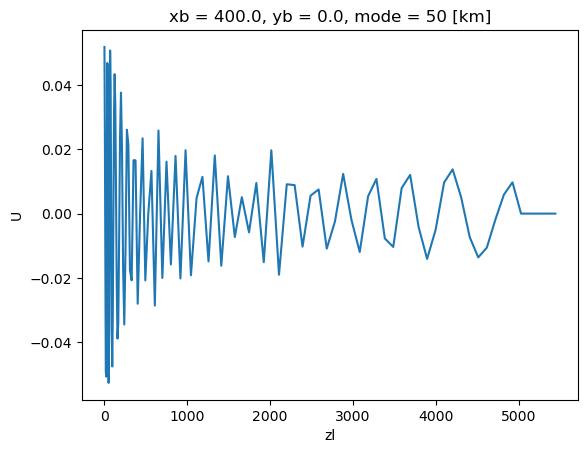

In [24]:
eigenf.U.isel(mode =50,xb = 0,yb = 0).plot()

In [73]:
data_idealtasman.rho.sel(xb = 800,yb = 0,method = "nearest")

<xarray.DataArray 'rho' (time: 401, zl: 100, yb: 25, xb: 376)> Size: 2GB
dask.array<getitem, shape=(401, 100, 25, 376), dtype=float32, chunksize=(281, 100, 6, 376), chunktype=numpy.ndarray>
Coordinates:
  * zl       (zl) float64 800B 2.704 8.126 13.58 ... 5.339e+03 5.443e+03
  * time     (time) float64 3kB 800.0 801.0 802.0 ... 1.199e+03 1.2e+03
  * xb       (xb) float64 3kB -0.0 4.0 8.0 12.0 ... 1.492e+03 1.496e+03 1.5e+03
  * yb       (yb) float64 200B -48.0 -44.0 -40.0 -36.0 ... 36.0 40.0 44.0 48.0
    zi       float64 8B ...
    lon      (yb, xb) float64 75kB dask.array<chunksize=(25, 376), meta=np.ndarray>
    lat      (yb, xb) float64 75kB dask.array<chunksize=(25, 376), meta=np.ndarray>
Attributes:
    _FillValue:    nan
    units:         kg m-3
    long_name:     Potential density referenced to 2000 dbar
    cell_methods:  area:mean z_l:mean yh:mean xh:mean time: point
    Description:   Beamwidth 400km, Beamlength 1500km, Resolution 4.0km, angl...
    coordinates:   lat lon

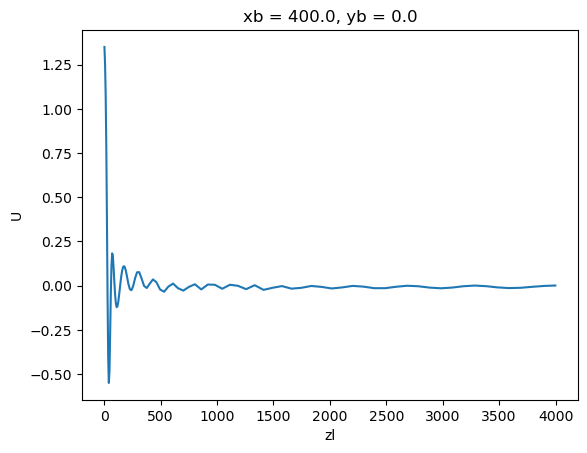

In [105]:
eigenf.U.sum("mode").plot()


Text(0.5, 1.0, 'Constant N (100 modes)')

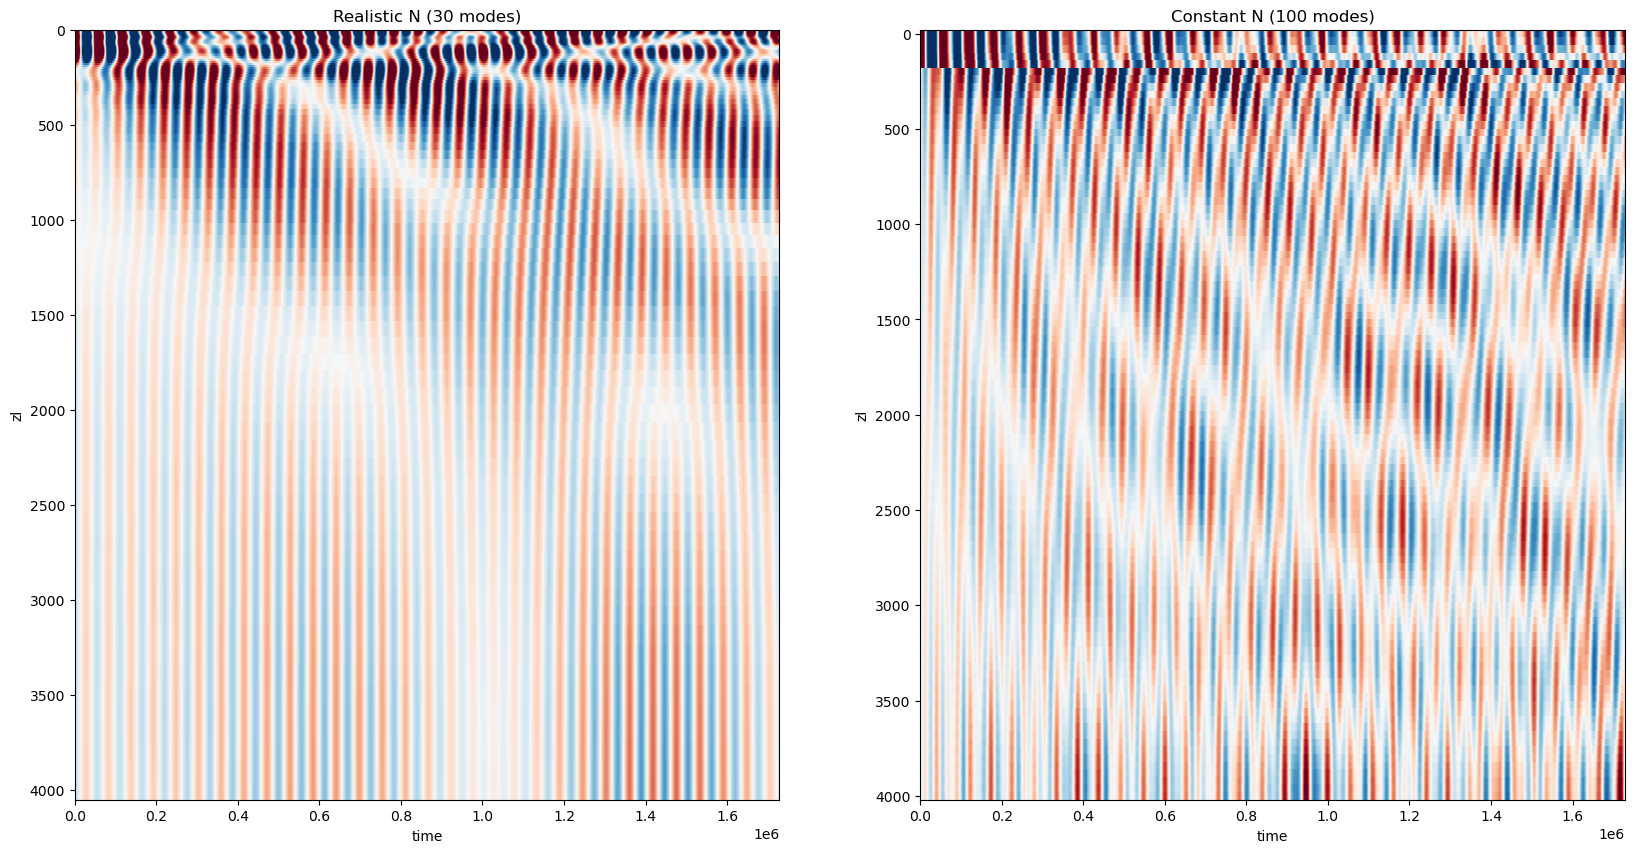

In [99]:
fig,ax = plt.subplots(1,2,figsize=(20,10))

u0 = data_idealtasman.rho.sel(xb = 800,yb = 0,method = "nearest").isel(time = 0) * 0
u0[0:25] = 1

u_varyN = u_decomp_varyN(u0,1,eigenf,l = l)

for i in range(1,len(eigenf.mode.values)):
    u_varyN += u_decomp_varyN(u0,i,eigenf,l = l)
    # plt.figure()

u_varyN.plot(ax = ax[0],vmin = -0.5,vmax = 0.5,cmap = "RdBu_r",add_colorbar = False)
ax[0].invert_yaxis()
ax[0].set_title("Realistic N (30 modes)")

u0 = xr.DataArray(
    np.zeros((101)),
    dims = "zl",
    coords = {"zl": np.linspace(0, H, 101)}
)

u0[0:5] = 1

u_constN = u_decomp_constN(u0,1,l = l)

for i in range(2,100):
    u_constN += u_decomp_constN(u0,i,l=l)
    # plt.figure()

u_constN.plot(ax = ax[1],cmap = "RdBu_r",vmin = -0.4,vmax = 0.4,add_colorbar = False)
ax[1].invert_yaxis()
ax[1].set_title("Constant N (100 modes)")




Text(0.5, 1.0, 'Constant N (100 modes)')

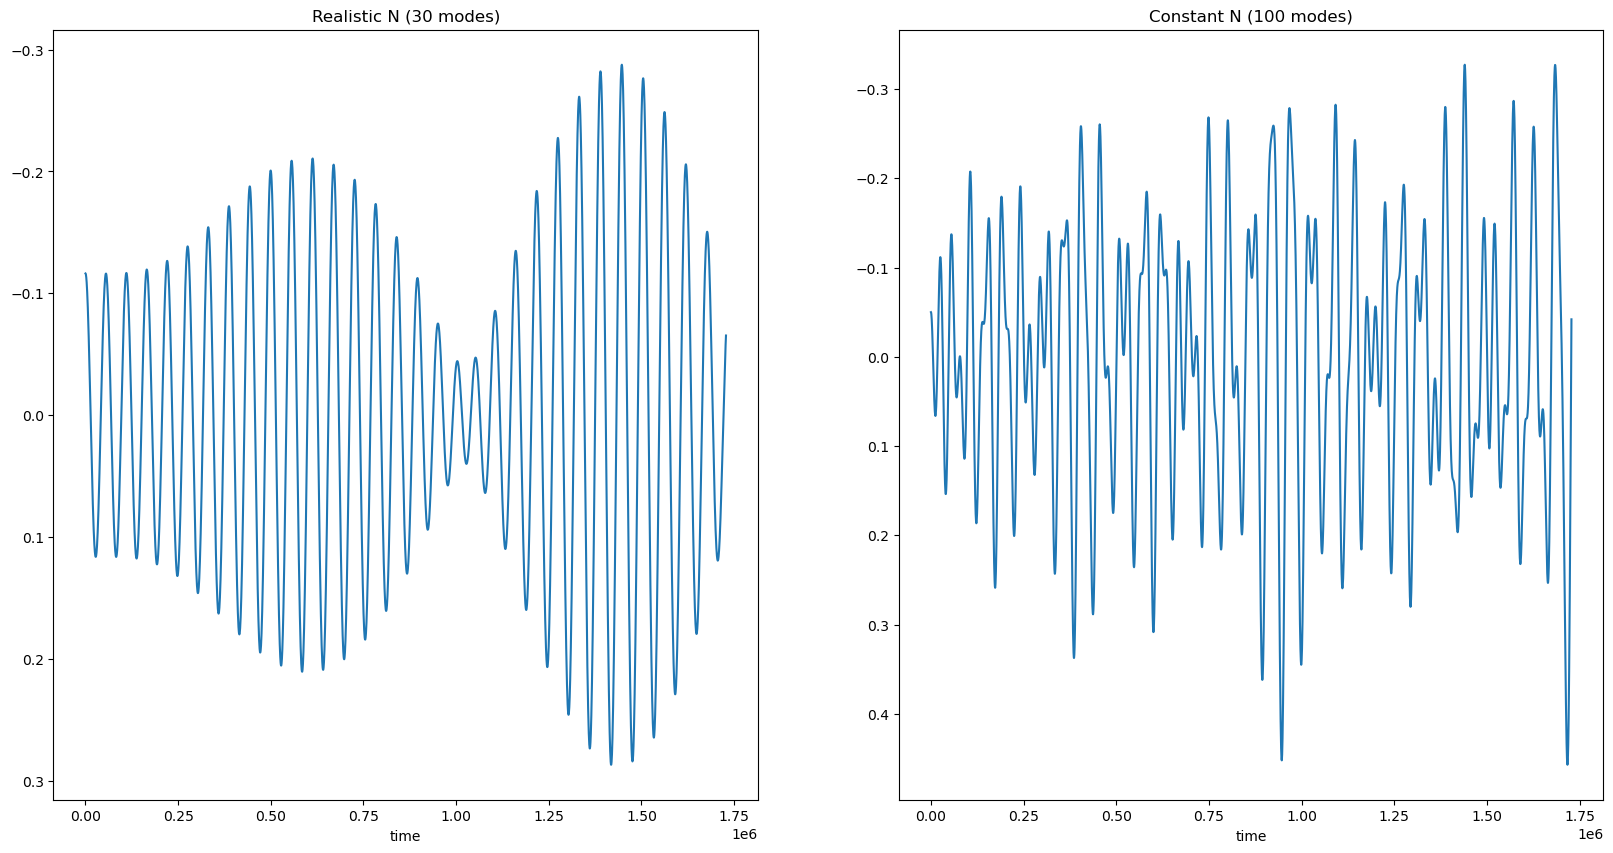

In [102]:
fig,ax = plt.subplots(1,2,figsize=(20,10))

u_varyN.isel(zl = -1).plot(ax = ax[0])
ax[0].invert_yaxis()
ax[0].set_title("Realistic N (30 modes)")

u_constN.isel(zl = -1).plot(ax = ax[1])
ax[1].invert_yaxis()
ax[1].set_title("Constant N (100 modes)")




## Decomposition with constant N

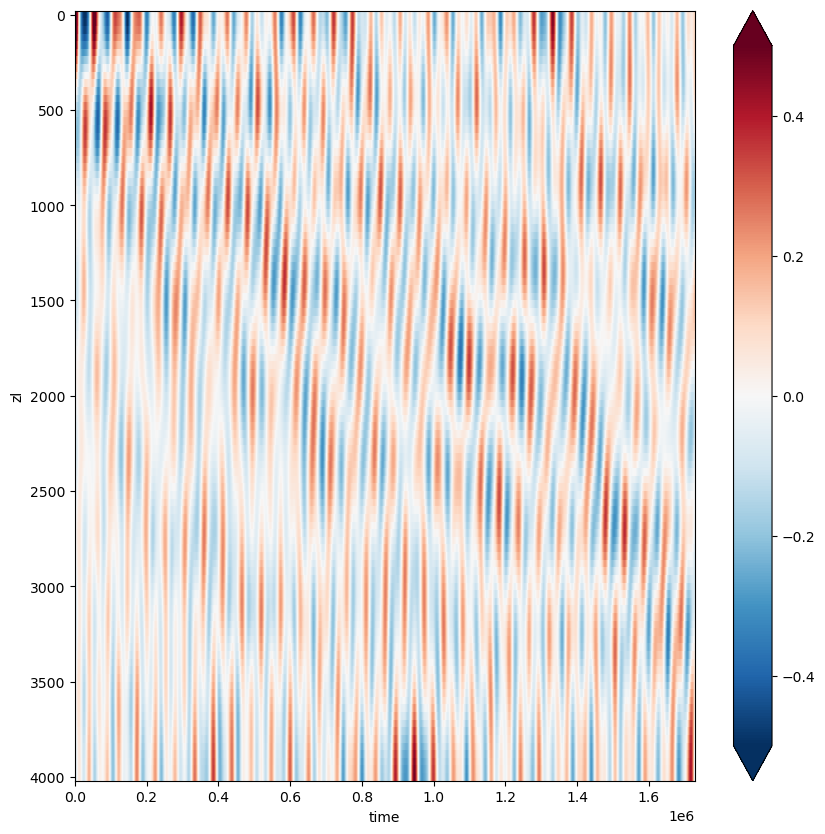

In [46]:
u_bottom = u_decomp_constN(u0,1,l = l)

for i in range(2,10):
    u_bottom += u_decomp_constN(u0,i,l=l)
    # plt.figure()

fig,ax = plt.subplots(1,1,figsize=(10,10))
u_bottom.plot(ax = ax,vmin = -0.5,vmax = 0.5,cmap = "RdBu_r")
ax.invert_yaxis()

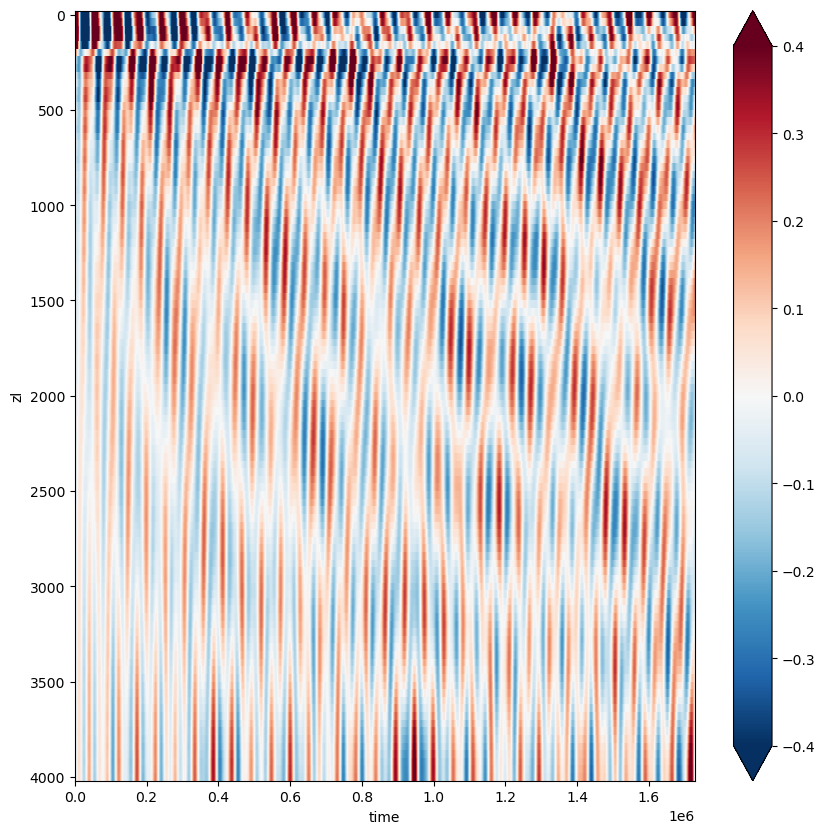

In [45]:
u0 = xr.DataArray(
    np.zeros((101)),
    dims = "zl",
    coords = {"zl": np.linspace(0, H, 101)}
)

u0[0:5] = 1

u_bottom = u_decomp_constN(u0,1,l = l)

for i in range(2,50):
    u_bottom += u_decomp_constN(u0,i,l=l)
    # plt.figure()

fig,ax = plt.subplots(1,1,figsize=(10,10))
u_bottom.plot(ax = ax,cmap = "RdBu_r",vmin = -0.4,vmax = 0.4)
ax.invert_yaxis()



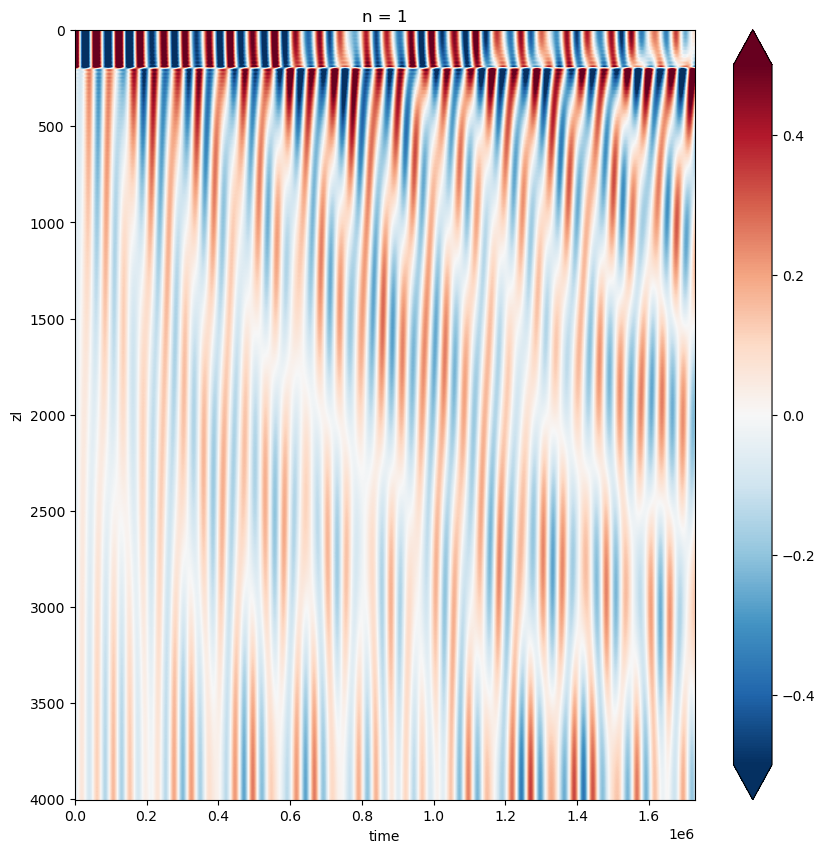

In [27]:
u_bottom = u_decomp(u0,1,An.sel(n=1))

for i in range(2,400):
    u_bottom += u_decomp(u0,i,An.sel(n=i))
    # plt.figure()

fig,ax = plt.subplots(1,1,figsize=(10,10))
u_bottom.plot(ax = ax,vmin = -0.5,vmax = 0.5,cmap = "RdBu_r")
ax.invert_yaxis()

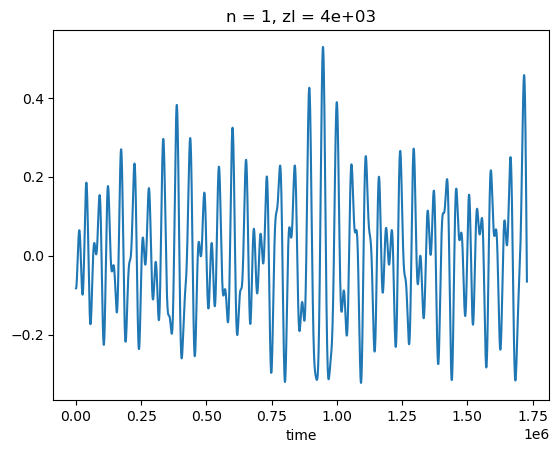

In [34]:
u_bottom.isel(zl = -1).plot()


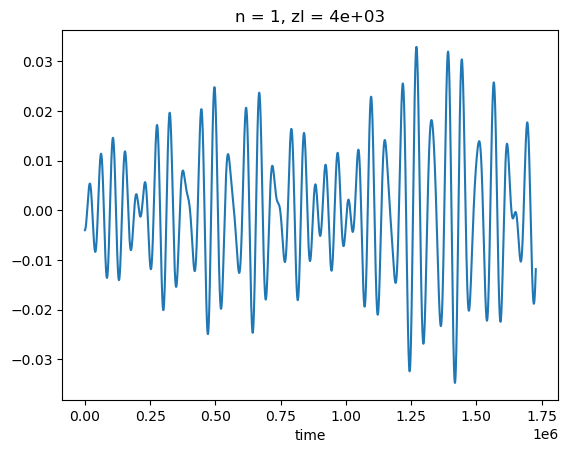

In [23]:
u_bottom.isel(zl = -1).plot()

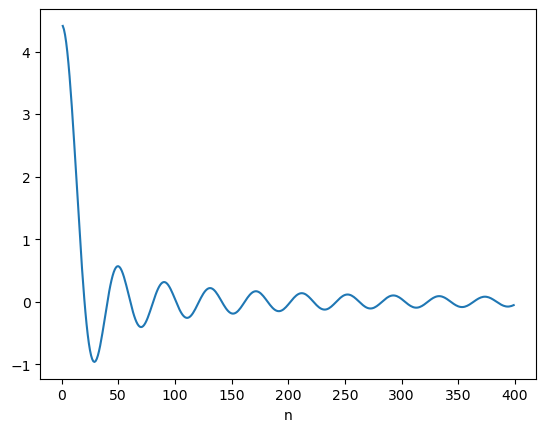

In [35]:
An.plot()